<a href="https://colab.research.google.com/github/Nahmadid/WeeklyReport/blob/main/new_pharma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**First Approach**

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import optax
import sys
import jax.nn as jnn
# import jaxopt

#@title **Doxorubicin**

import numpy as np
from scipy.integrate import odeint

#Defining the model
def Pharma(
    t,
    f1 = 0.0 ,
    V1 = 254.5 ,
    V2 = 1000,
    k  = 20,
):
    def func(y, t):

        return [
            -k * (y[0]/V1 - y[0]/V2) + f1,
            k  * (y[0]/V1 - y[1]/V2),
        ]

    # defining initial conditions for 6 state variables
    y0 = [1, 0]
    return odeint(func, y0, t)



t_dense = jnp.linspace(0, 14, 15)[:, None]
y_dense = Pharma(np.ravel(t_dense))


# Data
t_data = np.array([0, 1, 2, 4, 7, 14])
Q1_measured = np.array([1, 0.582, 0.402, 0.389, 0.3884, 0.3880])
Q2_measured = np.array([0, 0.418, 0.598, 0.611, 0.6115, 0.612])
data=np.column_stack([Q1_measured, Q2_measured]).astype(np.float32)
t_i  = jnp.array([[0]])
IC = data[:1, :].astype(np.float32)
IC

array([[1., 0.]], dtype=float32)

In [ ]:

# # Your data
# Q1_measured = [1, 0.582, 0.402, 0.389, 0.3884, 0.3880]
# Q2_measured = [0, 0.418, 0.598, 0.611, 0.6115, 0.612]

# # Determine the maximum length of the two lists
# max_length = max(len(Q1_measured), len(Q2_measured))

# # Create NumPy arrays with zero-padding
# Q1_padded = np.pad(Q1_measured, (0, max_length - len(Q1_measured)), mode='constant', constant_values=0)
# Q2_padded = np.pad(Q2_measured, (0, max_length - len(Q2_measured)), mode='constant', constant_values=0)

# # Stack the arrays horizontally
# data = np.column_stack([Q1_padded, Q2_padded]).astype(np.float32)

# # Initial conditions for Q1 and Q2
# IC = data[:1, :].astype(np.float32)

# (data, IC)


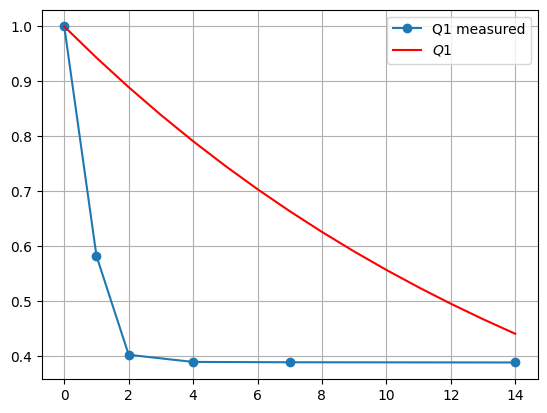

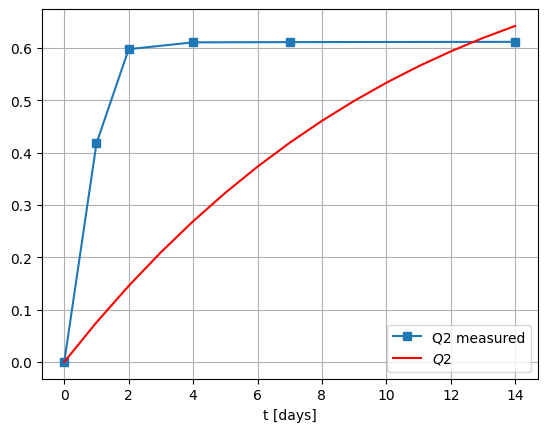

In [2]:
import matplotlib.pyplot as plt

plt.figure()


plt.plot(t_data, Q1_measured, marker='o', label='Q1 measured')
plt.plot(t_dense,y_dense[:,0],'r',label='$Q1$')
# Add a legend
plt.legend()
# Display the plot
plt.grid(True)
plt.show()
plt.figure()
plt.plot(t_data, Q2_measured, marker='s', label='Q2 measured')
plt.plot(t_dense,y_dense[:,1],'r',label='$Q2$')
# Add labels and title
plt.xlabel('t [days]')

# Add a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()


In [3]:
# tmin,tmax=0.
tmin, tmax = t_dense[0,0], t_dense[-1,0]

#t = (t-np.min(t))/(np.max(t)-np.min(t))
def init_params(layers):
    keys = jax.random.split(jax.random.PRNGKey(123), len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):
        W = jax.random.normal(key, shape=(n_in, n_out)) / jnp.sqrt(n_in) # random initialization
        B = jax.random.normal(key, shape=(n_out,))
        # params.append({'W': W, 'B': B , 'k1': 0.0 , 'k2': 0.0, 'l0': 0.0})
        params.append({'W': W, 'B': B })
    return params


def fwd(params,t):
  t = 0.01 * t
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
    # X = jnp.sin(X@layer['W']+layer['B'])
  return X@last['W'] + last['B']

def fwd_extra(params,t):
  t = 0.01 * t
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
  X = X@last['W'] + last['B']
  return X



@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)




In [4]:


def ODE_loss(t, y1, y2, ft):

    V1 = 254.5
    V2 = 1000
    f1 = 0.0
    k = jnn.softplus(ft(t))
    # k  = ft(t)

    y1_t = lambda t: jax.grad(lambda t: jnp.sum(y1(t)))(t)
    y2_t = lambda t: jax.grad(lambda t: jnp.sum(y2(t)))(t)

    ode1 = y1_t(t) + k * (y1(t)/V1 - y1(t)/V2)- f1
    ode2 = y2_t(t) - k * (y1(t)/V1 - y2(t)/V2)

    return ode1, ode2




#collocation points
N_c = 140

t_c = jnp.linspace(tmin, tmax, N_c+1)[:, None]

def loss_fun(params,params_extra, l1 ,l2 , t_i, t_d, t_c, data_IC, data):


    y1_func = lambda t: fwd(params, t)[:, [0]]
    y2_func = lambda t: fwd(params, t)[:, [1]]
    ft      = lambda t: fwd(params, t)[:, [2]]
    # ft     = lambda t: fwd_extra(params_extra, t)[:, [0]]



    # loss_y1, loss_y2, loss_y3 = ODE_loss(t_c, params, y1_func, y2_func, y3_func, f_t)
    loss_y1, loss_y2 = ODE_loss(t_c, y1_func, y2_func, ft)

    loss_y1 = l1*loss_y1
    loss_y2 = l2*loss_y2

    loss_ode1 = jnp.mean(loss_y1 ** 2)
    loss_ode2 = jnp.mean(loss_y2 ** 2)

    # Compute the loss for the initial conditions
    t_i = t_i.flatten()[:,None]
    pred_IC = jnp.concatenate([y1_func(t_i), y2_func(t_i)],axis=1)
    loss_IC = MSE(data_IC, pred_IC)

    # Compute the loss for Y_data
    t_d    = t_d.flatten()[:,None]
    pred_d = jnp.concatenate([y1_func(t_d), y2_func(t_d)],axis=1)
    loss_data = MSE(data, pred_d)

    #loss_data = MSE(data[:,0:3], pred_d[:,0:3])
    # loss_data = MSE(data[:, [0, 3]], pred_d[:, [0, 2]])


    return loss_IC, loss_data, loss_ode1, loss_ode2


# def loss_fun_total(params, params_extra,l1,l2, l3, t_i, t_d, t_c, data_IC, data, loss_weight):

#     loss_IC, loss_data, loss_ode1, loss_ode2, loss_ode3 = loss_fun(params, params_extra,l1,l2, l3, t_i, t_d, t_c, data_IC, data)

#     loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
#                 + loss_weight[2]*loss_ode1+ loss_weight[3]*loss_ode2\
#                 + loss_weight[4]*loss_ode3

#     return loss_total


def loss_fun_total(params, params_extra, l1,l2, t_i, t_d, t_c, data_IC, data, loss_weight):

    loss_IC, loss_data, loss_ode1, loss_ode2 = loss_fun(params, params_extra, l1,l2, t_i, t_d, t_c, data_IC, data)

    loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
                + loss_weight[2]*loss_ode1+ loss_weight[3]*loss_ode2

    return loss_total






# @jax.jit
# def update(opt_state, opt_state_extra, params, params_extra, params_l1, params_l2, params_l3, opt_state_l1,opt_state_l2, opt_state_l3, t_i, t_data, t_c, IC, data, loss_weight):
#   grads=jax.grad(loss_fun_total, argnums=[0,1,2,3,4])(params, params_extra,params_l1, params_l2, params_l3, t_i, t_data, t_c, IC, data, loss_weight)

#   #Update params
#   updates, opt_state = optimizer.update(grads[0], opt_state)
#   params = optax.apply_updates(params, updates)

#   updates_extra, opt_state_extra = optimizer_ex.update(grads[1], opt_state_extra)
#   params_extra = optax.apply_updates(params_extra, updates_extra)

#   updates_l1, opt_state_l1 = optimizer.update(-grads[2], opt_state_l1)
#   params_l1 = optax.apply_updates(params_l1, updates_l1)

#   updates_l2, opt_state_l2 = optimizer.update(-grads[3], opt_state_l2)
#   params_l2 = optax.apply_updates(params_l2, updates_l2)

#   updates_l3, opt_state_l3 = optimizer.update(-grads[4], opt_state_l3)
#   params_l3 = optax.apply_updates(params_l3, updates_l3)

#   return opt_state,params,opt_state_extra,params_extra, params_l1, params_l2, params_l3, opt_state_l1,opt_state_l2, opt_state_l3




@jax.jit
def update(opt_state, opt_state_extra, params, params_extra, params_l1, params_l2, opt_state_l1, opt_state_l2, t_i, t_data, t_c, IC, data, loss_weight):
  grads=jax.grad(loss_fun_total, argnums=[0,1,2,3])(params,params_extra, params_l1, params_l2, t_i, t_data, t_c, IC, data, loss_weight)

  #Update params
  updates, opt_state = optimizer.update(grads[0], opt_state)
  params = optax.apply_updates(params, updates)

  updates_extra, opt_state_extra = optimizer_ex.update(grads[1], opt_state_extra)
  params_extra = optax.apply_updates(params_extra, updates_extra)

  updates_l1, opt_state_l1 = optimizer.update(-grads[2], opt_state_l1)
  params_l1 = optax.apply_updates(params_l1, updates_l1)

  updates_l2, opt_state_l2 = optimizer.update(-grads[3], opt_state_l2)
  params_l2 = optax.apply_updates(params_l2, updates_l2)


  return opt_state, opt_state_extra, params, params_extra,  params_l1, params_l2, opt_state_l1, opt_state_l2





In [5]:
# construct the MLP of  4 hidden layers of 8 neurons for each layer
params = init_params([1] + [50]*6+[3])
params_extra = init_params([1] + [20]*4+[1])  # Initialize parameters for the extra neural network

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)
optimizer_ex = optax.adam(1e-3)
opt_state_extra = optimizer_ex.init(params_extra)


keys = jax.random.split(jax.random.PRNGKey(0), 10)
lambda_p = jax.random.uniform(keys[0], shape=(N_c + 1, 1))
lambda_1 = jax.random.uniform(keys[1], shape=(N_c + 1, 1))
lambda_2 = jax.random.uniform(keys[2], shape=(N_c + 1, 1))
lambda_3 = jax.random.uniform(keys[3], shape=(N_c + 1, 1))


opt_state_lp = optimizer.init(lambda_p)
opt_state_l1 = optimizer.init(lambda_1)
opt_state_l2 = optimizer.init(lambda_2)
opt_state_l3 = optimizer.init(lambda_3)


In [ ]:
#@title **two step training**


# start_time = time.time()
epochs_phase1 = 0#10000
epochs_phase2 = 50000
# loss_weight_phase1 = [1, 1, 1, 1, 1, 1]
loss_weight_phase1 = [1, 1, 0, 0]
loss_weight_phase2 = [1, 1, 1, 1]

loss_his, loss_indi_his, epoch_his = [], [], []

for ep in range(epochs_phase1 + epochs_phase2 + 1):
    if ep <= epochs_phase1:
        loss_weight = loss_weight_phase1
    else:
        loss_weight = loss_weight_phase2

    opt_state,opt_state_extra, params,params_extra,\
     params_l1, params_l2, opt_state_l1, opt_state_l2= update(opt_state,opt_state_extra, params, params_extra, lambda_1, lambda_2,\
                                                        opt_state_l1,opt_state_l2, t_i, t_data, t_c, IC, data, loss_weight)

    # print loss and epoch info
    if ep %(100) ==0:
      loss_val = loss_fun_total(params, params_extra, params_l1, params_l2, t_i, t_data, t_c, IC, data, loss_weight)
      loss_val_individual = loss_fun(params, params_extra, params_l1, params_l2, t_i, t_data, t_c, IC, data)
      epoch_his.append(ep)
      loss_his.append(loss_val)
      loss_indi_his.append(loss_val_individual)

    if ep %(1000) ==0:
      print(f'Epoch={ep}, \t , \t loss={loss_val:.2e}, \t loss_IC={loss_val_individual[0]:.2e}, \t loss_d={loss_val_individual[1]:.2e}, \t loss_e1={loss_val_individual[2]:.2e},\t loss_e2={loss_val_individual[3]:.2e}')
      # Append the values directly to the lists
      # kb_values_list.append(kb_updated)
      # kg_values_list.append(kg_updated)
      # np.savez(f'/content/drive/MyDrive/params_100_{ep}.npz', *params)

# end_time = time.time()

# running_time = end_time - start_time
# print(f"Total running time: {running_time:.2f} seconds")


Epoch=0, 	 , 	 loss=6.90e-01, 	 loss_IC=5.64e-01, 	 loss_d=1.27e-01, 	 loss_e1=1.67e-07,	 loss_e2=5.38e-09
Epoch=1000, 	 , 	 loss=5.97e-03, 	 loss_IC=1.24e-06, 	 loss_d=1.26e-03, 	 loss_e1=2.72e-03,	 loss_e2=1.98e-03
Epoch=2000, 	 , 	 loss=3.11e-03, 	 loss_IC=6.41e-06, 	 loss_d=5.51e-04, 	 loss_e1=1.60e-03,	 loss_e2=9.46e-04
Epoch=3000, 	 , 	 loss=3.44e-03, 	 loss_IC=1.92e-03, 	 loss_d=3.94e-04, 	 loss_e1=7.30e-04,	 loss_e2=3.96e-04
Epoch=4000, 	 , 	 loss=6.42e-04, 	 loss_IC=1.50e-04, 	 loss_d=1.76e-04, 	 loss_e1=2.54e-04,	 loss_e2=6.22e-05
Epoch=5000, 	 , 	 loss=5.34e-04, 	 loss_IC=1.80e-04, 	 loss_d=9.55e-05, 	 loss_e1=1.74e-04,	 loss_e2=8.37e-05
Epoch=6000, 	 , 	 loss=1.39e-04, 	 loss_IC=3.11e-05, 	 loss_d=2.05e-05, 	 loss_e1=6.97e-05,	 loss_e2=1.81e-05
Epoch=7000, 	 , 	 loss=1.21e-04, 	 loss_IC=3.10e-05, 	 loss_d=1.65e-05, 	 loss_e1=5.32e-05,	 loss_e2=1.99e-05
Epoch=8000, 	 , 	 loss=8.69e-05, 	 loss_IC=1.82e-05, 	 loss_d=1.21e-05, 	 loss_e1=4.48e-05,	 loss_e2=1.18e-05
Epoch=9000, 	

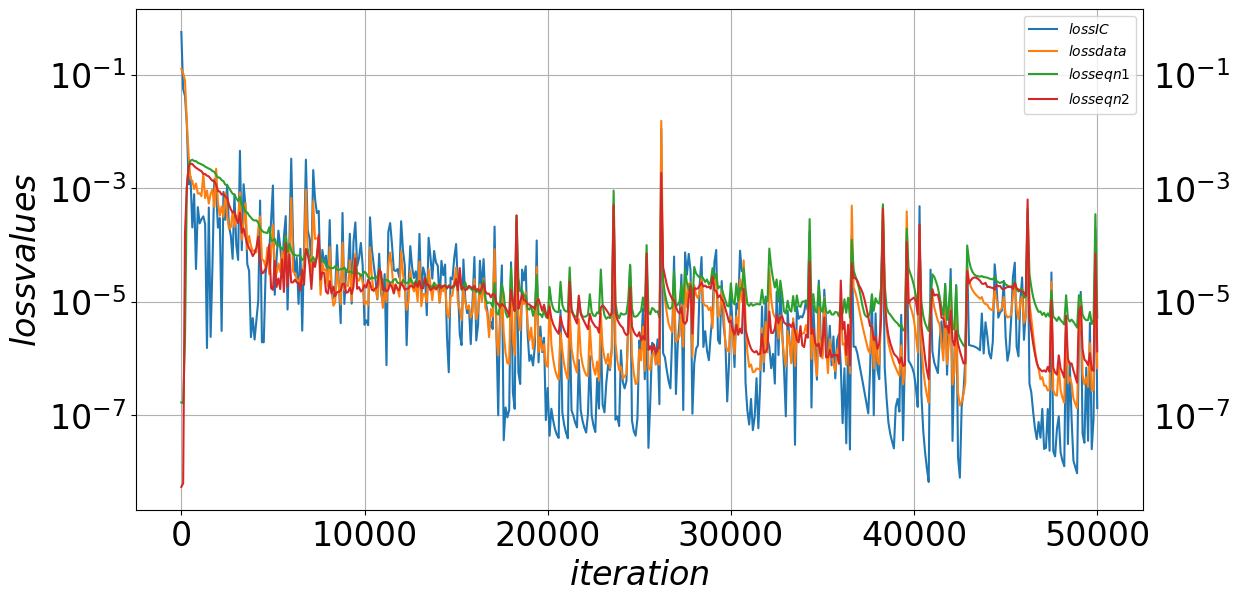

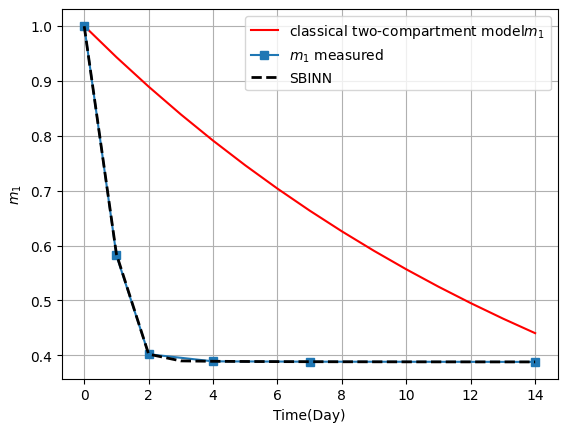

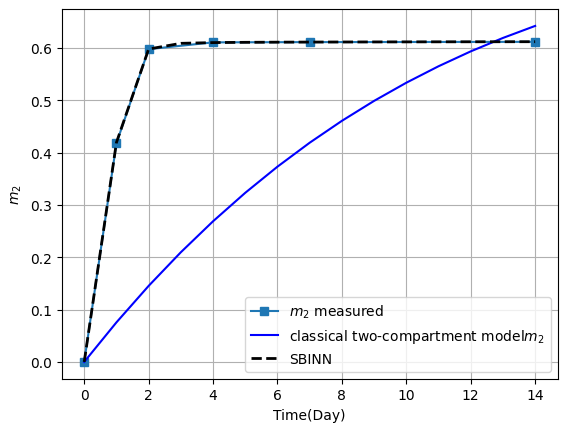

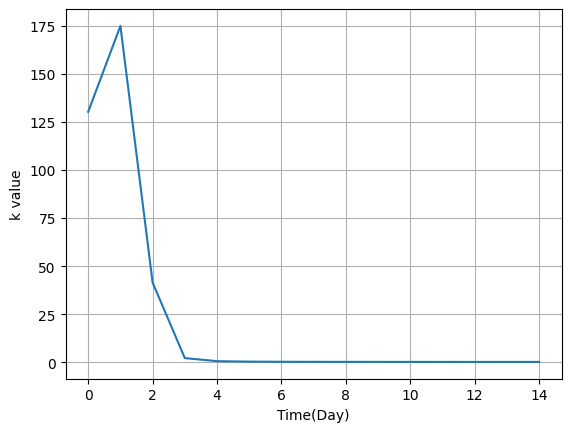

In [ ]:
!pip install gplearn
from gplearn.functions import make_function
import numpy as np
# Import necessary modules
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.random import check_random_state
from gplearn.genetic import SymbolicRegressor
import pandas as pd


SAVE_FIG = False
#History of loss
font = 24
fig, ax = plt.subplots()
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=6)
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
plt.xlabel('$iteration$', fontsize = font)
plt.ylabel('$loss values$', fontsize = font)
plt.yscale('log')
plt.grid(True)
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,0], label='$loss IC$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,1], label='$loss data$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,2], label='$loss eqn1$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,3], label='$loss eqn2$')
plt.legend(loc="upper right",  fontsize = 24, ncol=4)
plt.legend()
ax.tick_params(axis='both', labelsize = 24)
fig.set_size_inches(w=13,h=6.5)
if SAVE_FIG:
    plt.savefig(save_results_to +'History_loss.png', dpi=300)






pred = fwd(params,t_dense)

ft =pred[:,2]
k = jnn.softplus(ft)
t_pred = t_dense
df_f = pd.DataFrame({"t": np.ravel(t_dense), "ft": np.ravel(k) })
df_f.to_csv("./k_pharma.csv", index=False)


plt.figure()
# k = pred[:, 2]
plt.plot(t_dense,y_dense[:,0],'r',label='classical two-compartment model$m_1$')
plt.plot(t_data, Q1_measured, marker='s', label='$m_1$ measured')
plt.plot(t_dense,pred[:,0],'--k',label='SBINN',linewidth=2)
plt.xlabel('Time(Day)')
plt.ylabel('$m_1$')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t_data, Q2_measured, marker='s', label='$m_2$ measured')
plt.plot(t_dense,y_dense[:,1],'b',label='classical two-compartment model$m_2$')
plt.plot(t_dense,pred[:,1],'--k',label='SBINN',linewidth=2)
plt.xlabel('Time(Day)')
plt.ylabel('$m_2$')
plt.legend()
plt.grid(True)



plt.figure()
plt.plot(t_dense, k)
plt.xlabel('Time(Day)')
plt.ylabel('k value')
plt.grid(True)


# kg = 0.72
# kb = 0.15
# G0 = 0.1

# # Calculate f_t using the provided equations
# f_t_analytical = kg * y_dense[:, 0] - kb * y_dense[:, 1]*10
# f_t_neural = fwd_extra(loaded_params_extra, t_dense)[:, 0]*10

# f_t_err = f_t_analytical - f_t_neural
# # F_SR= 0.739 *y_dense[:, 0]- 0.141* y_dense[:, 1]
# F_SR= 0.712 *y_dense[:, 0]#- 0.141* y_dense[:, 1]
# # f_t_neural = fwd_extra(loaded_params_extra, t_dense)[:, 0]
# # Plot both f_t values
# plt.plot(t_dense, f_t, label='$f(t)$ (exact) = 0.72 G + 0.15 B')
# plt.plot(t_dense, f_t_neural,'r',linewidth=2, label='f(t) PINN', alpha=0.3)
# # plt.plot(t_dense, f_t_err,'--b',linewidth=2, label='f(t) PINN', alpha=0.3)
# # plt.plot(t_dense, F_SR ,'--k', label='$f(t)$ (Symbolic Regression)= 0.739 G + 0.141 B ')
# plt.grid()
# plt.xlabel('t')
# plt.ylabel('$f(t)$')
# plt.title('Result of 100 data points')
# plt.legend()
# plt.show()



# # plt.plot(T,fwd(params_extra,T.reshape(-1,1)),'--k',label='NN[G]',linewidth=2)

# plt.legend()



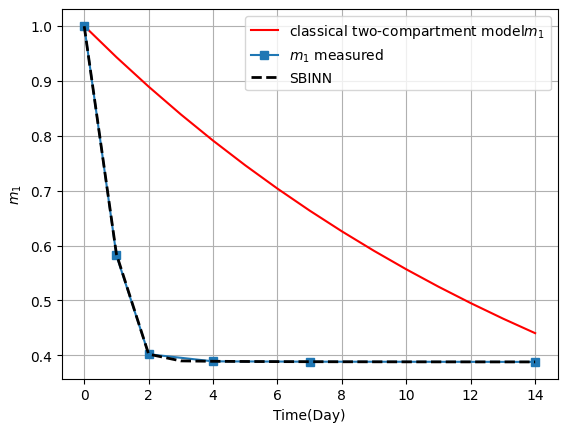

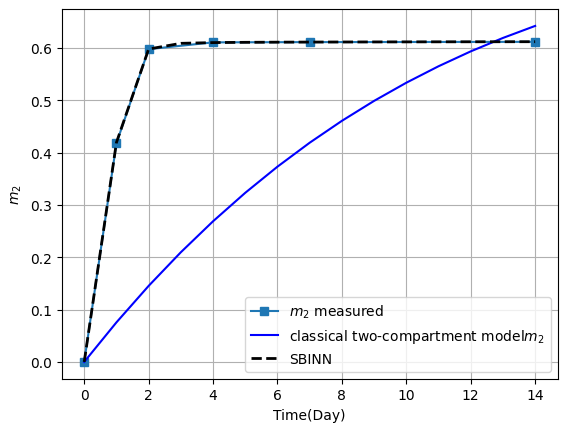

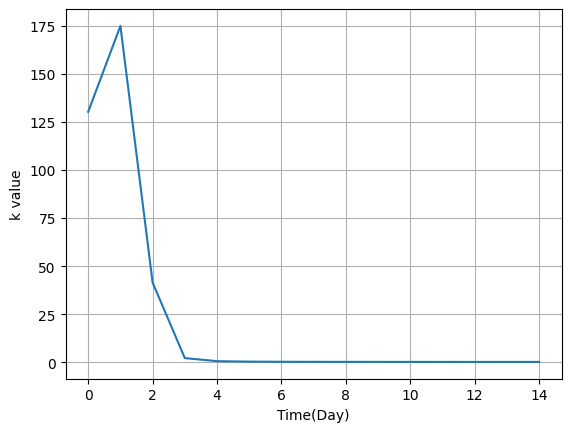

In [ ]:

!pip install gplearn
from gplearn.functions import make_function
import numpy as np
# Import necessary modules
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.random import check_random_state
from gplearn.genetic import SymbolicRegressor
import pandas as pd




pred = fwd(params,t_dense)

ft =pred[:,2]
k = jnn.softplus(ft)
t_pred = t_dense
df_f = pd.DataFrame({"t": np.ravel(t_dense), "ft": np.ravel(k) })
df_f.to_csv("./k_pharma.csv", index=False)



# k = pred[:, 2]
plt.plot(t_dense,y_dense[:,0],'r',label='classical two-compartment model$m_1$')
plt.plot(t_data, Q1_measured, marker='s', label='$m_1$ measured')
plt.plot(t_dense,pred[:,0],'--k',label='SBINN',linewidth=2)
plt.xlabel('Time(Day)')
plt.ylabel('$m_1$')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t_data, Q2_measured, marker='s', label='$m_2$ measured')
plt.plot(t_dense,y_dense[:,1],'b',label='classical two-compartment model$m_2$')
plt.plot(t_dense,pred[:,1],'--k',label='SBINN',linewidth=2)
plt.xlabel('Time(Day)')
plt.ylabel('$m_2$')
plt.legend()
plt.grid(True)



plt.figure()
plt.plot(t_dense, k)
plt.xlabel('Time(Day)')
plt.ylabel('k value')
plt.grid(True)


# kg = 0.72
# kb = 0.15
# G0 = 0.1

# # Calculate f_t using the provided equations
# f_t_analytical = kg * y_dense[:, 0] - kb * y_dense[:, 1]*10
# f_t_neural = fwd_extra(loaded_params_extra, t_dense)[:, 0]*10

# f_t_err = f_t_analytical - f_t_neural
# # F_SR= 0.739 *y_dense[:, 0]- 0.141* y_dense[:, 1]
# F_SR= 0.712 *y_dense[:, 0]#- 0.141* y_dense[:, 1]
# # f_t_neural = fwd_extra(loaded_params_extra, t_dense)[:, 0]
# # Plot both f_t values
# plt.plot(t_dense, f_t, label='$f(t)$ (exact) = 0.72 G + 0.15 B')
# plt.plot(t_dense, f_t_neural,'r',linewidth=2, label='f(t) PINN', alpha=0.3)
# # plt.plot(t_dense, f_t_err,'--b',linewidth=2, label='f(t) PINN', alpha=0.3)
# # plt.plot(t_dense, F_SR ,'--k', label='$f(t)$ (Symbolic Regression)= 0.739 G + 0.141 B ')
# plt.grid()
# plt.xlabel('t')
# plt.ylabel('$f(t)$')
# plt.title('Result of 100 data points')
# plt.legend()
# plt.show()



# # plt.plot(T,fwd(params_extra,T.reshape(-1,1)),'--k',label='NN[G]',linewidth=2)

# plt.legend()


In [ ]:
!pip install gplearn
from gplearn.functions import make_function
import numpy as np
# Import necessary modules
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.random import check_random_state
from gplearn.genetic import SymbolicRegressor
import pandas as pd

In [ ]:
import pandas as pd
ft =pred[:,2]
k = jnn.softplus(ft)
t_pred = t_dense
df_f = pd.DataFrame({"t": np.ravel(t_dense), "ft": np.ravel(k) })
df_f.to_csv("./k_pharma.csv", index=False)

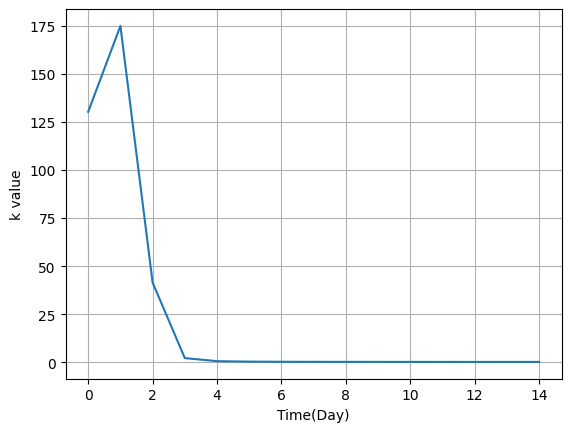

In [ ]:

ft =pred[:,2]
plt.figure()
plt.plot(t_dense, k)
plt.xlabel('Time(Day)')
plt.ylabel('k value')
plt.grid(True)

In [ ]:
k

Array([130.18927   , 174.78978   ,  41.481342  ,   2.2587438 ,
         0.66003317,   0.42515996,   0.351712  ,   0.31879866,
         0.30103543,   0.29037464,   0.2835638 ,   0.27905023,
         0.27599952,   0.27392447,   0.27251455], dtype=float32)

In [ ]:
data = pd.read_csv("./k_pharma.csv")
# function_set = ['add', 'mul', 'sub']
# Separate the data into the 'Ii' and 'f3' variables
data_X = data['t'].values.reshape(-1, 1)
f_NN = data['ft'].values
# # Define and train the symbolic regressor
# est_gp = SymbolicRegressor(population_size=50000,
#                            generations=20, stopping_criteria=0.001,
#                            p_crossover=0.7, p_subtree_mutation=0.1,
#                            p_hoist_mutation=0.05, p_point_mutation=0.1,
#                            max_samples=0.9, verbose=1,
#                            parsimony_coefficient=0.01, random_state=0,function_set=function_set)

est_gp = SymbolicRegressor(population_size=5000,
                           generations=20, stopping_criteria=0.001,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)

est_gp.fit(data_X, f_NN)

# Print the equation
print(est_gp._program)



    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    48.81      3.89308e+07       31          3.21094          145.735      1.65m
   1    31.82          2389.22        7          3.39553          152.097      1.36m
   2    29.32          3322.66       21          2.67925          262.014      1.27m
   3    29.33           5443.2       73          2.94458          67.5851      1.13m
   4    38.26          2367.95      143         0.795557          85.3081      1.13m
   5    59.63          743.439       79         0.671582          20.3658      1.31m
   6    66.22          13069.2       79           0.6767           21.009      1.23m
   7    66.98           217.67       59         0.585365          20.5321      1.21m
   8    68.64            77528       71         0.585922          20.9488  

In [ ]:
data = pd.read_csv("./k_pharma.csv")
# function_set = ['add', 'mul', 'sub']
# Separate the data into the 'Ii' and 'f3' variables
data_X = data['t'].values.reshape(-1, 1)
f_NN = data['ft'].values
# # Define and train the symbolic regressor
# est_gp = SymbolicRegressor(population_size=50000,
#                            generations=20, stopping_criteria=0.001,
#                            p_crossover=0.7, p_subtree_mutation=0.1,
#                            p_hoist_mutation=0.05, p_point_mutation=0.1,
#                            max_samples=0.9, verbose=1,
#                            parsimony_coefficient=0.01, random_state=0,function_set=function_set)

est_gp = SymbolicRegressor(population_size=10000,
                           generations=20, stopping_criteria=0.001,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)

est_gp.fit(data_X, f_NN)

# Print the equation
print(est_gp._program)



    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    49.27      1.56087e+08       31          3.21094          145.735      3.54m
   1    32.59      1.16309e+06       27          2.94441           161.02      2.62m
   2    32.00          8541.54      123         0.624857          90.5554      2.40m
   3    35.25          39068.7       97          1.99162           86.166      2.25m
   4    44.56          20174.6       51          1.01384           107.87      2.42m
   5    60.19           137123      147         0.530061          85.3067      2.39m
   6    77.96          80470.5      133         0.571545          85.3067      2.58m
   7    88.72           137090      119         0.456668           56.554      2.61m
   8    97.45          5623.75      111         0.174392          30.8711  

#**Second approach**

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import optax
import sys
import jax.nn as jnn
# import jaxopt

#@title **Doxorubicin**

import numpy as np
from scipy.integrate import odeint

#Defining the model
def Pharma(
    t,
    f1 = 0.0 ,
    V1 = 254.5 ,
    V2 = 1000,
    k  = 20,
):
    def func(y, t):

        return [
            -k * (y[0]/V1 - y[0]/V2) + f1,
            k  * (y[0]/V1 - y[1]/V2),
        ]

    # defining initial conditions for 6 state variables
    y0 = [1, 0]
    return odeint(func, y0, t)



t_dense = jnp.linspace(0, 14, 15)[:, None]
y_dense = Pharma(np.ravel(t_dense))


# Data
t_data = np.array([0, 1, 2, 4, 7, 14])
Q1_measured = np.array([1, 0.582, 0.402, 0.389, 0.3884, 0.3880])
Q2_measured = np.array([0, 0.418, 0.598, 0.611, 0.6115, 0.612])
data=np.column_stack([Q1_measured, Q2_measured]).astype(np.float32)
t_i  = jnp.array([[0]])
IC = data[:1, :].astype(np.float32)
IC

array([[1., 0.]], dtype=float32)

In [ ]:
# tmin,tmax=0.
tmin, tmax = t_dense[0,0], t_dense[-1,0]

#t = (t-np.min(t))/(np.max(t)-np.min(t))
def init_params(layers):
    keys = jax.random.split(jax.random.PRNGKey(123), len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):
        W = jax.random.normal(key, shape=(n_in, n_out)) / jnp.sqrt(n_in) # random initialization
        B = jax.random.normal(key, shape=(n_out,))
        # params.append({'W': W, 'B': B , 'k1': 0.0 , 'k2': 0.0, 'l0': 0.0})
        params.append({'W': W, 'B': B })
    return params


def fwd(params,t):
  t = 0.01 * t
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
    # X = jnp.sin(X@layer['W']+layer['B'])
  return X@last['W'] + last['B']

def fwd_extra(params,t):
  t = 0.01 * t
  X = jnp.concatenate([t],axis=1)
  *hidden,last = params
  for layer in hidden :
    X = jax.nn.tanh(X@layer['W']+layer['B'])
  X = X@last['W'] + last['B']
  return X



@jax.jit
def MSE(true,pred):
  return jnp.mean((true-pred)**2)


#################################################################################

def ODE_loss(t, y1, y2, ft):

    V1 = 254.5
    V2 = 1000
    f1 = 0.0
    ft = ft(t)
    # ft = jnn.softplus(ft(t))
    k  = 20
    # k  = ft(t)

    y1_t = lambda t: jax.grad(lambda t: jnp.sum(y1(t)))(t)
    y2_t = lambda t: jax.grad(lambda t: jnp.sum(y2(t)))(t)

    ode1 = y1_t(t) + k * (y1(t)/V1 - y1(t)/V2)- f1 - ft
    ode2 = y2_t(t) - k * (y1(t)/V1 - y2(t)/V2)

    return ode1, ode2




#collocation points
N_c = 140

t_c = jnp.linspace(tmin, tmax, N_c+1)[:, None]

def loss_fun(params,params_extra, l1 ,l2 , t_i, t_d, t_c, data_IC, data):


    y1_func = lambda t: fwd(params, t)[:, [0]]
    y2_func = lambda t: fwd(params, t)[:, [1]]
    ft      = lambda t: fwd(params, t)[:, [2]]
    # ft     = lambda t: fwd_extra(params_extra, t)[:, [0]]



    # loss_y1, loss_y2, loss_y3 = ODE_loss(t_c, params, y1_func, y2_func, y3_func, f_t)
    loss_y1, loss_y2 = ODE_loss(t_c, y1_func, y2_func, ft)

    loss_y1 = l1*loss_y1
    loss_y2 = l2*loss_y2

    loss_ode1 = jnp.mean(loss_y1 ** 2)
    loss_ode2 = jnp.mean(loss_y2 ** 2)

    # Compute the loss for the initial conditions
    t_i = t_i.flatten()[:,None]
    pred_IC = jnp.concatenate([y1_func(t_i), y2_func(t_i)],axis=1)
    loss_IC = MSE(data_IC, pred_IC)

    # Compute the loss for Y_data
    t_d    = t_d.flatten()[:,None]
    pred_d = jnp.concatenate([y1_func(t_d), y2_func(t_d)],axis=1)
    loss_data = MSE(data, pred_d)

    #loss_data = MSE(data[:,0:3], pred_d[:,0:3])
    # loss_data = MSE(data[:, [0, 3]], pred_d[:, [0, 2]])


    return loss_IC, loss_data, loss_ode1, loss_ode2


def loss_fun_total(params, params_extra, l1,l2, t_i, t_d, t_c, data_IC, data, loss_weight):

    loss_IC, loss_data, loss_ode1, loss_ode2 = loss_fun(params, params_extra, l1,l2, t_i, t_d, t_c, data_IC, data)

    loss_total = loss_weight[0]*loss_IC+ loss_weight[1]*loss_data\
                + loss_weight[2]*loss_ode1+ loss_weight[3]*loss_ode2

    return loss_total





@jax.jit
def update(opt_state, opt_state_extra, params, params_extra, params_l1, params_l2, opt_state_l1, opt_state_l2, t_i, t_data, t_c, IC, data, loss_weight):
  grads=jax.grad(loss_fun_total, argnums=[0,1,2,3])(params,params_extra, params_l1, params_l2, t_i, t_data, t_c, IC, data, loss_weight)

  #Update params
  updates, opt_state = optimizer.update(grads[0], opt_state)
  params = optax.apply_updates(params, updates)

  updates_extra, opt_state_extra = optimizer_ex.update(grads[1], opt_state_extra)
  params_extra = optax.apply_updates(params_extra, updates_extra)

  updates_l1, opt_state_l1 = optimizer.update(-grads[2], opt_state_l1)
  params_l1 = optax.apply_updates(params_l1, updates_l1)

  updates_l2, opt_state_l2 = optimizer.update(-grads[3], opt_state_l2)
  params_l2 = optax.apply_updates(params_l2, updates_l2)


  return opt_state, opt_state_extra, params, params_extra,  params_l1, params_l2, opt_state_l1, opt_state_l2


################################################################################
# construct the MLP of  4 hidden layers of 8 neurons for each layer
params = init_params([1] + [50]*6+[3])
params_extra = init_params([1] + [20]*4+[1])  # Initialize parameters for the extra neural network

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)
optimizer_ex = optax.adam(1e-3)
opt_state_extra = optimizer_ex.init(params_extra)


keys = jax.random.split(jax.random.PRNGKey(0), 10)
lambda_p = jax.random.uniform(keys[0], shape=(N_c + 1, 1))
lambda_1 = jax.random.uniform(keys[1], shape=(N_c + 1, 1))
lambda_2 = jax.random.uniform(keys[2], shape=(N_c + 1, 1))
lambda_3 = jax.random.uniform(keys[3], shape=(N_c + 1, 1))


opt_state_lp = optimizer.init(lambda_p)
opt_state_l1 = optimizer.init(lambda_1)
opt_state_l2 = optimizer.init(lambda_2)
opt_state_l3 = optimizer.init(lambda_3)






In [ ]:
#@title **two step training**


# start_time = time.time()
epochs_phase1 = 0#10000
epochs_phase2 = 50000
# loss_weight_phase1 = [1, 1, 1, 1, 1, 1]
loss_weight_phase1 = [1, 1, 0, 0]
loss_weight_phase2 = [1, 1, 1, 1]

loss_his, loss_indi_his, epoch_his = [], [], []

for ep in range(epochs_phase1 + epochs_phase2 + 1):
    if ep <= epochs_phase1:
        loss_weight = loss_weight_phase1
    else:
        loss_weight = loss_weight_phase2

    opt_state,opt_state_extra, params,params_extra,\
     params_l1, params_l2, opt_state_l1, opt_state_l2= update(opt_state,opt_state_extra, params, params_extra, lambda_1, lambda_2,\
                                                        opt_state_l1,opt_state_l2, t_i, t_data, t_c, IC, data, loss_weight)

    # print loss and epoch info
    if ep %(100) ==0:
      loss_val = loss_fun_total(params, params_extra, params_l1, params_l2, t_i, t_data, t_c, IC, data, loss_weight)
      loss_val_individual = loss_fun(params, params_extra, params_l1, params_l2, t_i, t_data, t_c, IC, data)
      epoch_his.append(ep)
      loss_his.append(loss_val)
      loss_indi_his.append(loss_val_individual)

    if ep %(1000) ==0:
      print(f'Epoch={ep}, \t , \t loss={loss_val:.2e}, \t loss_IC={loss_val_individual[0]:.2e}, \t loss_d={loss_val_individual[1]:.2e}, \t loss_e1={loss_val_individual[2]:.2e},\t loss_e2={loss_val_individual[3]:.2e}')
      # Append the values directly to the lists
      # kb_values_list.append(kb_updated)
      # kg_values_list.append(kg_updated)
      # np.savez(f'/content/drive/MyDrive/params_100_{ep}.npz', *params)

# end_time = time.time()

# running_time = end_time - start_time
# print(f"Total running time: {running_time:.2f} seconds")


Epoch=0, 	 , 	 loss=6.90e-01, 	 loss_IC=5.64e-01, 	 loss_d=1.27e-01, 	 loss_e1=1.44e-01,	 loss_e2=1.23e-05
Epoch=1000, 	 , 	 loss=3.94e-03, 	 loss_IC=7.53e-04, 	 loss_d=3.67e-04, 	 loss_e1=7.28e-05,	 loss_e2=2.75e-03
Epoch=2000, 	 , 	 loss=3.05e-03, 	 loss_IC=6.88e-05, 	 loss_d=3.21e-04, 	 loss_e1=5.10e-05,	 loss_e2=2.61e-03
Epoch=3000, 	 , 	 loss=2.32e-03, 	 loss_IC=6.12e-05, 	 loss_d=1.41e-04, 	 loss_e1=3.12e-05,	 loss_e2=2.08e-03
Epoch=4000, 	 , 	 loss=1.74e-03, 	 loss_IC=1.86e-05, 	 loss_d=1.12e-04, 	 loss_e1=3.54e-05,	 loss_e2=1.58e-03
Epoch=5000, 	 , 	 loss=1.70e-03, 	 loss_IC=1.65e-05, 	 loss_d=1.39e-04, 	 loss_e1=4.81e-05,	 loss_e2=1.50e-03
Epoch=6000, 	 , 	 loss=1.51e-03, 	 loss_IC=1.23e-05, 	 loss_d=8.59e-05, 	 loss_e1=6.53e-06,	 loss_e2=1.41e-03
Epoch=7000, 	 , 	 loss=1.54e-03, 	 loss_IC=7.96e-06, 	 loss_d=1.07e-04, 	 loss_e1=3.06e-06,	 loss_e2=1.43e-03
Epoch=8000, 	 , 	 loss=1.45e-03, 	 loss_IC=2.28e-05, 	 loss_d=7.92e-05, 	 loss_e1=9.38e-06,	 loss_e2=1.34e-03
Epoch=9000, 	

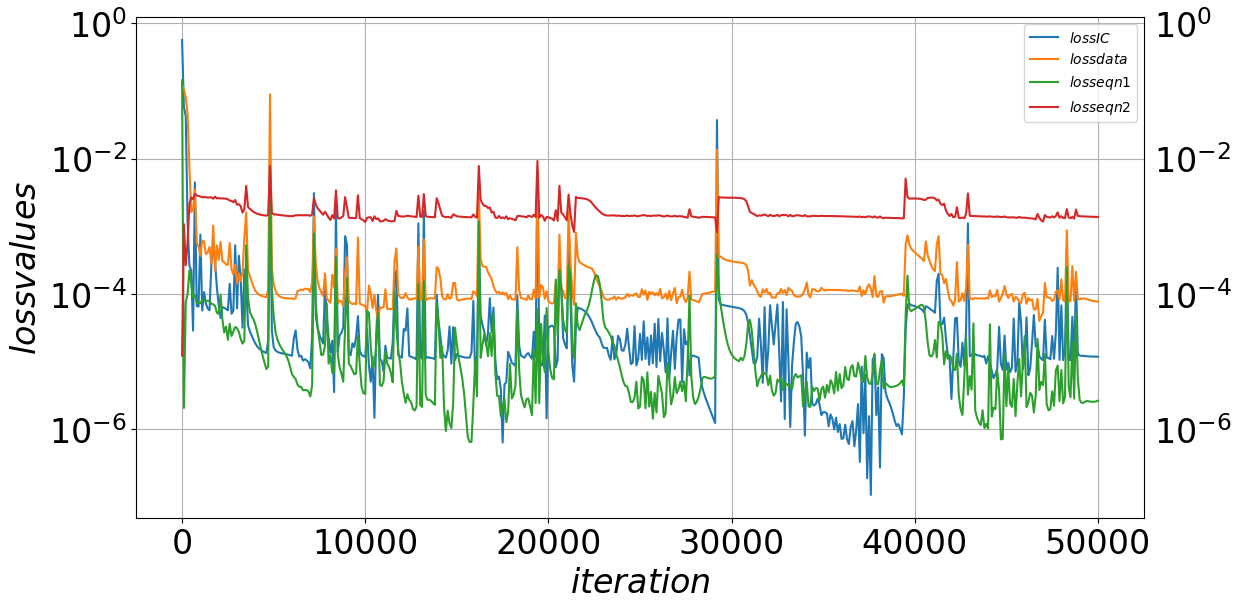

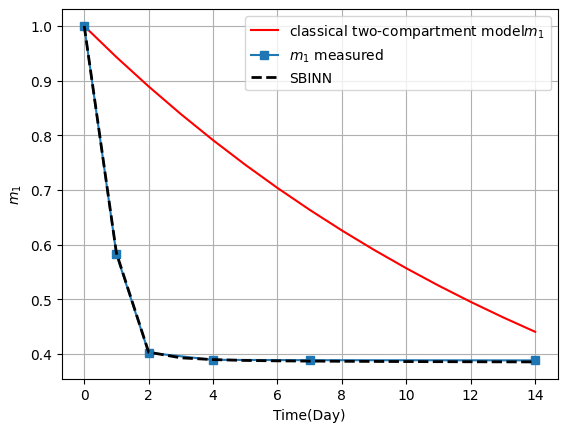

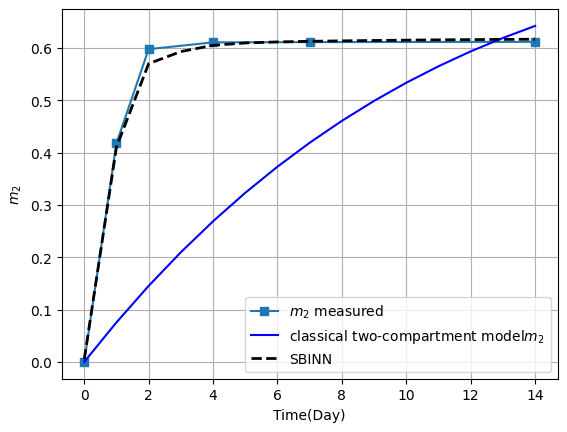

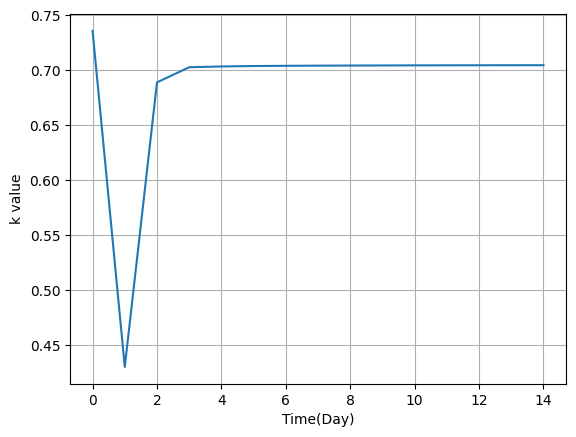

In [ ]:
!pip install gplearn
from gplearn.functions import make_function
import numpy as np
# Import necessary modules
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.random import check_random_state
from gplearn.genetic import SymbolicRegressor
import pandas as pd


SAVE_FIG = False
#History of loss
font = 24
fig, ax = plt.subplots()
plt.locator_params(axis='x', nbins=6)
plt.locator_params(axis='y', nbins=6)
plt.tick_params(axis='y', which='both', labelleft='on', labelright='off')
plt.xlabel('$iteration$', fontsize = font)
plt.ylabel('$loss values$', fontsize = font)
plt.yscale('log')
plt.grid(True)
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,0], label='$loss IC$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,1], label='$loss data$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,2], label='$loss eqn1$')
plt.plot(epoch_his, np.asarray(loss_indi_his)[:,3], label='$loss eqn2$')
plt.legend(loc="upper right",  fontsize = 24, ncol=4)
plt.legend()
ax.tick_params(axis='both', labelsize = 24)
fig.set_size_inches(w=13,h=6.5)
if SAVE_FIG:
    plt.savefig(save_results_to +'History_loss.png', dpi=300)






pred = fwd(params,t_dense)

ft =pred[:,2]
k = jnn.softplus(ft)
t_pred = t_dense
df_f = pd.DataFrame({"t": np.ravel(t_dense), "ft": np.ravel(k) })
df_f.to_csv("./k_pharma.csv", index=False)


plt.figure()
# k = pred[:, 2]
plt.plot(t_dense,y_dense[:,0],'r',label='classical two-compartment model$m_1$')
plt.plot(t_data, Q1_measured, marker='s', label='$m_1$ measured')
plt.plot(t_dense,pred[:,0],'--k',label='SBINN',linewidth=2)
plt.xlabel('Time(Day)')
plt.ylabel('$m_1$')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(t_data, Q2_measured, marker='s', label='$m_2$ measured')
plt.plot(t_dense,y_dense[:,1],'b',label='classical two-compartment model$m_2$')
plt.plot(t_dense,pred[:,1],'--k',label='SBINN',linewidth=2)
plt.xlabel('Time(Day)')
plt.ylabel('$m_2$')
plt.legend()
plt.grid(True)



plt.figure()
plt.plot(t_dense, k)
plt.xlabel('Time(Day)')
plt.ylabel('k value')
plt.grid(True)


# kg = 0.72
# kb = 0.15
# G0 = 0.1

# # Calculate f_t using the provided equations
# f_t_analytical = kg * y_dense[:, 0] - kb * y_dense[:, 1]*10
# f_t_neural = fwd_extra(loaded_params_extra, t_dense)[:, 0]*10

# f_t_err = f_t_analytical - f_t_neural
# # F_SR= 0.739 *y_dense[:, 0]- 0.141* y_dense[:, 1]
# F_SR= 0.712 *y_dense[:, 0]#- 0.141* y_dense[:, 1]
# # f_t_neural = fwd_extra(loaded_params_extra, t_dense)[:, 0]
# # Plot both f_t values
# plt.plot(t_dense, f_t, label='$f(t)$ (exact) = 0.72 G + 0.15 B')
# plt.plot(t_dense, f_t_neural,'r',linewidth=2, label='f(t) PINN', alpha=0.3)
# # plt.plot(t_dense, f_t_err,'--b',linewidth=2, label='f(t) PINN', alpha=0.3)
# # plt.plot(t_dense, F_SR ,'--k', label='$f(t)$ (Symbolic Regression)= 0.739 G + 0.141 B ')
# plt.grid()
# plt.xlabel('t')
# plt.ylabel('$f(t)$')
# plt.title('Result of 100 data points')
# plt.legend()
# plt.show()



# # plt.plot(T,fwd(params_extra,T.reshape(-1,1)),'--k',label='NN[G]',linewidth=2)

# plt.legend()

